In [1]:
import json
import os
import subprocess

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 

No pytransport functionality
No pytransport functionality


# LOAD LINE

In [25]:
def find_axis_intercepts(x_coords, y_coords):
    x_intercepts = []
    y_intercepts = []

    for i in range(len(x_coords)):
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % len(x_coords)], y_coords[(i + 1) % len(y_coords)]

        if x1 == x2:
        # Vertical line, no y-intercept
            y_intercept = 0.0 if x1 == x2 == 0.0 else None
        else:
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - (slope * x1)

        if y1 == y2:
        # Horizontal line, no x-intercept
            x_intercept = 0.0 if y1 == y2 == 0.0 else None
        else:
            slope = (x2 - x1) / (y2 - y1)
            x_intercept = x1 - (slope * y1)

        # Check if the x-intercept is within the range of x1 and x2
        if x_intercept is not None and (x1 <= x_intercept <= x2 or x2 <= x_intercept <= x1):
            x_intercepts.append(x_intercept)

        # Check if the y-intercept is within the range of y1 and y2
        if y_intercept is not None and (y1 <= y_intercept <= y2 or y2 <= y_intercept <= y1):
            y_intercepts.append(y_intercept)

    return x_intercepts, y_intercepts



def find_bad_offset_apertures(line):
    aperture_offsets = {}
    for name, element in line.element_dict.items():
        if 'offset' in name and element.__class__.__name__.startswith('XYShift'):
            aper_name = name.split('_offset')[0]
            aperture_offsets[aper_name] = (element.dx, element.dy)

    bad_apers = {}
    print('vmabc.4l2.b.b2_aper' in aperture_offsets.keys())
    for ap_name, offset in aperture_offsets.items():
        aperture_el = line.element_dict[ap_name]

        cname= aperture_el.__class__.__name__
        ap_dict = aperture_el.to_dict()

        if cname == 'LimitEllipse':
            x_min = -ap_dict['a']
            x_max = ap_dict['a']
            y_min = -ap_dict['b']
            y_max = ap_dict['b']
        elif cname == 'LimitRect':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRectEllipse':
            x_min = -ap_dict['max_x']
            x_max = ap_dict['max_x']
            y_min = -ap_dict['max_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRacetrack':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitPolygon':
            x_intercepts, y_intercepts = find_axis_intercepts(ap_dict['x_vertices'],
                                                            ap_dict['y_vertices'])
            x_min = min(x_intercepts)
            x_max = max(x_intercepts)
            y_min = min(y_intercepts)
            y_max = max(y_intercepts)

        tolerance = 5e-3
        """if (x_max - offset[0] < tolerance 
            or -x_min + offset[0] < tolerance 
            or y_max - offset[1] < tolerance 
            or -y_min + offset[1] < tolerance):"""
        if (offset[0] -x_max > tolerance 
            or  -offset[0] + x_min > tolerance 
            or  offset[1] - y_max > tolerance 
            or  -offset[1] + y_min > tolerance ):
                bad_apers[ap_name] = (x_min, x_max, y_min, y_max, offset[0], offset[1])

    return bad_apers



In [26]:
config_file ='config_sim.yaml'

with open(config_file, 'r') as stream:
    config_dict = yaml.safe_load(stream)

coll_file = config_dict['input_files']['collimators']
with open(coll_file, 'r') as stream:
    coll_dict = yaml.safe_load(stream)['collimators']['b'+config_dict['run']['beam']]


run_dict = config_dict['run']
file_dict = config_dict['input_files']


context = xo.ContextCpu(omp_num_threads='auto')

# On a modern CPU, we get ~5000 particle*turns/s
# So this script should take around half an hour
beam          = run_dict['beam']
plane         = run_dict['plane']

num_turns     = run_dict['turns']
num_particles = run_dict['nparticles']
engine        = run_dict['engine']

TTCS_align_angle_step = run_dict['TTCS_align_angle_step']

#--------------------------------------------------
num_turns     = 100 #run_dict['turns']
num_particles = 200 #run_dict['nparticles']
mode = 'monitors' #run_dict['mode']
#--------------------------------------------------

path_out = Path.cwd() / 'Outputdata'

if not path_out.exists():
    os.makedirs(path_out)


# Load from json
line = xt.Line.from_json(file_dict[f'line_b{beam}'])

end_s = line.get_length()

TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
TCLA_name = 'tcla.a5l3.b2'


TCCS_loc = end_s - 6773.7 #6775
TCCP_loc = end_s - 6653.3 #6655
TARGET_loc = end_s - (6653.3 + coll_dict[TCCP_name]["length"]/2 + coll_dict[TARGET_name]["length"]/2)
TCLA_loc = line.get_s_position()[line.element_names.index(TCLA_name)]




line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)
line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCS_name+'_aper')
line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name=TARGET_name)
line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TARGET_name+'_aper')
line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name=TCCP_name)
line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCP_name+'_aper')


TCCS_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
TARGET_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
dx = 1e-11
line.insert_element(at_s = TCCS_loc - coll_dict[TCCS_name]["length"]/2 - dx, element=TCCS_monitor, name='TCCS_monitor')
line.insert_element(at_s = TARGET_loc - coll_dict[TARGET_name]["length"]/2 - dx, element=TARGET_monitor, name='TARGET_monitor')

#line.cycle(name_first_element='ip3', inplace=True)

bad_aper = find_bad_offset_apertures(line)
print('Bad apertures : ', bad_aper)
print('Replace bad apertures with Marker')
for name in bad_aper.keys():
    line.element_dict[name] = xt.Marker()
    print(name, line.get_s_position(name), line.element_dict[name])



# Aperture model check
print('\nAperture model check on imported model:')
df_imported = line.check_aperture()
assert not np.any(df_imported.has_aperture_problem)


print('\n Before collimator manager')
for i, n in enumerate(line.element_names):
    if n.startswith("TCCS"):
        print(i, n)

# Initialise collmanager
coll_manager = xc.CollimatorManager.from_yaml(file_dict['collimators'], line=line, beam=beam, _context=context, ignore_crystals=False)


#print(coll_manager.collimator_names)

# Install collimators into line
if engine == 'everest':
    coll_names = coll_manager.collimator_names

    if mode == 'cry_black_absorbers':
        black_absorbers = ['target.4l3.b2', 'tccs.5r3.b2']
    elif mode == 'angular_scan': 
        black_absorbers = ['target.4l3.b2',]
    else: 
        black_absorbers = []

    everest_colls = [name for name in coll_names if name not in black_absorbers]
    coll_manager.install_everest_collimators(names=everest_colls,verbose=True)
    coll_manager.install_black_absorbers(names = black_absorbers, verbose=True)


else:
    raise ValueError(f"Unknown scattering engine {engine}!")

print('\n After collimator manager')
for i, n in enumerate(line.element_names):
    if n.startswith("TCCS"):
        print(i, n)


# Aperture model check
print('\nAperture model check after introducing collimators:')
df_with_coll = line.check_aperture()
assert not np.any(df_with_coll.has_aperture_problem)



    
# Build the tracker
coll_manager.build_tracker()



# Set the collimator openings based on the colldb,
# or manually override with the option gaps={collname: gap}
coll_manager.set_openings()


if mode == 'angular_scan':
    print("\nTTCS aligned to beam: ", line[TTCS_name].align_angle)
    #line[TTCS_name].align_angle = TTCS_align_angle_step

    line[TTCS_name].align_angle = line[TTCS_name].align_angle + TTCS_align_angle_step
    print("TTCS align angle incremented by step: ", line[TTCS_name].align_angle)


# Aperture model check
print('\nAperture model check after introducing collimators:')
df_with_coll = line.check_aperture()

#assert not np.any(df_with_coll.has_aperture_probl

Done loading line from dict.           
True
Bad apertures :  {'tctph.4r8.a.b2_aper': (-0.04, 0.04, -0.04, 0.04, 0.16672558295218318, -0.0), 'vmabc.4l2.b.b2_aper': (-0.0315, 0.0315, -0.0315, 0.0315, -0.18383135991897473, -0.0)}
Replace bad apertures with Marker
tctph.4r8.a.b2_aper 3461.1485832278486 Marker(_dummy=0)
vmabc.4l2.b.b2_aper 23206.82195866583 Marker(_dummy=0)

Aperture model check on imported model:
Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]

 Before collimator manager
77296 TCCS_monitor
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Installing tcl.4l1.b2           as EverestCollimator
Installing tcl.5l1.b2           as EverestCollimator
Installing tcl.6l1.b2           as EverestCollimator
Installing tctph.4r8.b2         as EverestCollimator
Installing tctpv.4r8.b2         as EverestCollimator
Installing tdisa.a4r8.b2        as EverestCol

/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)



Aperture model check after introducing collimators:
Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]


#### MULTITURN ANALYSIS

    # Generate initial pencil distribution on horizontal collimator
    tcp  = f"tcp.{'c' if plane=='H' else 'd'}6{'l' if beam=='1' else 'r'}7.b{beam}"
    part = coll_manager.generate_pencil_on_collimator(tcp, num_particles=num_particles)


    # Optimise the line
    #line.optimize_for_tracking()
    idx = line.element_names.index(tcp)
    part.at_element = idx
    part.start_tracking_at_element = idx


    # Track
    coll_manager.enable_scattering()
    line.track(part, num_turns=num_turns, time=True)
    coll_manager.disable_scattering()
    print(f"Done tracking in {line.time_last_track:.1f}s.")


    # Save lossmap to json, which can be loaded, combined (for more statistics),
    # and plotted with the 'lossmaps' package
    _ = coll_manager.lossmap(part, file=Path(path_out,f'lossmap_B{beam}{plane}.json'))


    # Save a summary of the collimator losses to a text file
    summary = coll_manager.summary(part) #, file=Path(path_out,f'coll_summary_B{beam}{plane}.out')
    print(summary)

    if mode == 'cry_black_absorbers':
        df_part = part.to_pandas()
        df_part.to_hdf(Path(path_out,f'particles_B{beam}{plane}.h5'), key='df', mode='w') 


    if mode == 'monitors':
        TCCS_monitor_dict = TCCS_monitor.to_dict()
        TARGET_monitor_dict = TARGET_monitor.to_dict()
        with open(Path(path_out,f'TCCS_monitor_B{beam}{plane}.pkl'), 'wb') as f:
            pickle.dump(TCCS_monitor_dict, f)
        with open(Path(path_out,f'TARGET_monitor_B{beam}{plane}.pkl'), 'wb') as f:
            pickle.dump(TARGET_monitor_dict, f)
        

In [27]:
twiss = line.twiss()
beta_y_optics = twiss['bety',TCCS_name]
alfa_y_optics = twiss['alfy',TCCS_name]
normalized_emittance = 3.5e-6
emittance_phy = normalized_emittance/(line.particle_ref._xobject.beta0[0]*line.particle_ref._xobject.gamma0[0])
sigma = np.sqrt(emittance_phy*beta_y_optics)

In [28]:
idx_TCCS = line.element_names.index(TCCS_name)
idx_TARGET = line.element_names.index(TARGET_name)
idx_TCCP = line.element_names.index(TCCP_name)

In [29]:
line.elements[idx_TCCS].jaw_L/sigma

5.0

#### Crystal


In [30]:
getattr(line.elements[idx_TCCS], 'jaw_L')

0.0016912979598174786

In [31]:
line.elements[idx_TCCS].align_angle

-1.1763616021881982e-05

In [32]:
line.elements[idx_TCCS].to_dict()

{'__class__': 'EverestCrystal',
 'inactive_front': 0.0,
 'active_length': 0.004,
 'inactive_back': 0.0,
 'active': 1,
 'align_angle': -1.1763616021881982e-05,
 'bend': 80.0,
 'xdim': 0.002,
 'ydim': 0.035,
 'thick': 0.0,
 'miscut': 0.0,
 'rutherford_rng': {'__class__': 'RandomRutherford',
  'lower_val': 0.0009982,
  'upper_val': 0.02,
  'A': 0.0016160247264725453,
  'B': 166.49518410000002,
  'Newton_iterations': 7},
 '_tracking': 0,
 'angle': 90.0,
 'tilt': 0.0,
 'jaw': None,
 'reference_center': [-1.7331272144205038e-06, -6.174001066619167e-07],
 'side': 'left',
 'lattice': 'strip',
 'material': {'__class__': 'CrystalMaterial',
  'Z': 14.0,
  'A': 28.08,
  'density': 2.33,
  'excitation_energy': 1.73e-07,
  'nuclear_radius': 0.441,
  'nuclear_elastic_slope': 120.14,
  'cross_section': array([6.64e-01, 4.30e-01, 0.00e+00, 0.00e+00, 0.00e+00, 3.90e-04]),
  'hcut': 0.02,
  'name': 'Silicon',
  'crystal_radiation_length': 0.0937,
  'crystal_nuclear_length': 0.4652,
  'crystal_plane_dista

In [33]:
coll_dict[TCCS_name]

{'parking': 0.025,
 'gap': 5.0,
 'stage': 'special',
 'material': 'Si',
 'side': 'left',
 'angle': 90,
 'crystal': 'strip',
 'active': True,
 'length': 0.004,
 'bend': 80.0,
 'xdim': 0.002,
 'ydim': 0.035}

In [34]:
print(f"ParticleAnalysis(element_type=\'crystal\', n_sigma={coll_dict[TCCS_name]['gap']}, length={coll_dict[TCCS_name]['length']}, ydim={coll_dict[TCCS_name]['xdim']}, xdim={coll_dict[TCCS_name]['ydim']}, bend={coll_dict[TCCS_name]['bend']}, align_angle={line.elements[idx_TCCS].align_angle}, jaw_L={line.elements[idx_TCCS].jaw_L})")

ParticleAnalysis(element_type='crystal', n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-1.1763616021881982e-05, jaw_L=0.0016912979598174786)


#### Target

In [35]:
line.elements[idx_TARGET]

EverestCollimator(inactive_front=0.0, active_length=0.005, inactive_back=0.0, jaw_L=0.00923702412365808, jaw_R=-0.025, ref_x=5.122714843017597e-07, ref_y=-1.2329827900582934e-06, sin_zL=1.0, cos_zL=6.123233995736766e-17, sin_zR=1.0, cos_zR=6.123233995736766e-17, sin_yL=0.0, cos_yL=1.0, tan_yL=1.0, sin_yR=0.0, cos_yR=1.0, tan_yR=1.0, _side=1, active=1, _internal_record_id=RecordIdentifier(buffer_id=0, offset=0), _material=Material(Z=67.7, A=166.7, density=18.0, excitation_energy=6.822e-07, nuclear_radius=0.578, nuclear_elastic_slope=392.1, cross_section=[2.548   1.473   0.      0.      0.      0.00574], hcut=0.02, name=Inermet, radiation_length=0.00385), rutherford_rng=RandomRutherford(lower_val=0.0009982, upper_val=0.02, A=0.0020688250909133275, B=286.00931239999994, Newton_iterations=7), _tracking=0)

In [36]:
line.elements[idx_TARGET].to_dict()

{'__class__': 'EverestCollimator',
 'inactive_front': 0.0,
 'active_length': 0.005,
 'inactive_back': 0.0,
 'active': 1,
 'rutherford_rng': {'__class__': 'RandomRutherford',
  'lower_val': 0.0009982,
  'upper_val': 0.02,
  'A': 0.0020688250909133275,
  'B': 286.00931239999994,
  'Newton_iterations': 7},
 '_tracking': 0,
 'angle': 90.0,
 'tilt': 0.0,
 'jaw': None,
 'reference_center': [5.122714843017597e-07, -1.2329827900582934e-06],
 'side': 'left',
 'material': {'__class__': 'Material',
  'Z': 67.7,
  'A': 166.7,
  'density': 18.0,
  'excitation_energy': 6.822e-07,
  'nuclear_radius': 0.578,
  'nuclear_elastic_slope': 392.1,
  'cross_section': array([2.548  , 1.473  , 0.     , 0.     , 0.     , 0.00574]),
  'hcut': 0.02,
  'name': 'Inermet',
  'radiation_length': 0.00385}}

In [37]:
coll_dict[TARGET_name]

{'parking': 0.025,
 'gap': 25,
 'stage': 'special',
 'material': 'Iner',
 'side': 'left',
 'angle': 90,
 'active': True,
 'length': 0.005,
 'xdim': 0.004,
 'ydim': 0.008}

In [38]:
print(f"ParticleAnalysis(element_type=\'target\', n_sigma={coll_dict[TARGET_name]['gap']}, length={coll_dict[TARGET_name]['length']}, ydim={coll_dict[TARGET_name]['xdim']}, xdim={coll_dict[TARGET_name]['ydim']}, jaw_L={line.elements[idx_TARGET].jaw_L})")

ParticleAnalysis(element_type='target', n_sigma=25, length=0.005, ydim=0.004, xdim=0.008, jaw_L=0.00923702412365808)


#### TCCP

In [39]:
line.elements[idx_TCCP]

EverestCrystal(inactive_front=0.0, active_length=0.07, inactive_back=0.0, jaw_L=0.00923752213290674, jaw_R=-0.025, ref_x=5.124118326191422e-07, ref_y=-1.2330519940453663e-06, sin_zL=1.0, cos_zL=6.123233995736766e-17, sin_zR=1.0, cos_zR=6.123233995736766e-17, sin_yL=0.0, cos_yL=1.0, tan_yL=1.0, sin_yR=0.0, cos_yR=1.0, tan_yR=1.0, _side=1, active=1, _internal_record_id=RecordIdentifier(buffer_id=0, offset=0), align_angle=9.960227831544705e-05, bend=10.0, xdim=0.002, ydim=0.008, thick=0.0, miscut=0.0, _orient=1, _material=CrystalMaterial(Z=14.0, A=28.08, density=2.33, excitation_energy=1.73e-07, nuclear_radius=0.441, nuclear_elastic_slope=120.14, cross_section=[6.64e-01 4.30e-01 0.00e+00 0.00e+00 0.00e+00 3.90e-04], hcut=0.02, name=Silicon, crystal_radiation_length=0.0937, crystal_nuclear_length=0.4652, crystal_plane_distance=9.6e-08, crystal_potential=21.34, nuclear_collision_length=0.3016), rutherford_rng=RandomRutherford(lower_val=0.0009982, upper_val=0.02, A=0.0016160247264725453, B=1

In [40]:
line.elements[idx_TCCP].to_dict()

{'__class__': 'EverestCrystal',
 'inactive_front': 0.0,
 'active_length': 0.07,
 'inactive_back': 0.0,
 'active': 1,
 'align_angle': 9.960227831544705e-05,
 'bend': 10.0,
 'xdim': 0.002,
 'ydim': 0.008,
 'thick': 0.0,
 'miscut': 0.0,
 'rutherford_rng': {'__class__': 'RandomRutherford',
  'lower_val': 0.0009982,
  'upper_val': 0.02,
  'A': 0.0016160247264725453,
  'B': 166.49518410000002,
  'Newton_iterations': 7},
 '_tracking': 0,
 'angle': 90.0,
 'tilt': 0.0,
 'jaw': None,
 'reference_center': [5.124118326191422e-07, -1.2330519940453663e-06],
 'side': 'left',
 'lattice': 'strip',
 'material': {'__class__': 'CrystalMaterial',
  'Z': 14.0,
  'A': 28.08,
  'density': 2.33,
  'excitation_energy': 1.73e-07,
  'nuclear_radius': 0.441,
  'nuclear_elastic_slope': 120.14,
  'cross_section': array([6.64e-01, 4.30e-01, 0.00e+00, 0.00e+00, 0.00e+00, 3.90e-04]),
  'hcut': 0.02,
  'name': 'Silicon',
  'crystal_radiation_length': 0.0937,
  'crystal_nuclear_length': 0.4652,
  'crystal_plane_distance'

In [41]:
coll_dict[TARGET_name]

{'parking': 0.025,
 'gap': 25,
 'stage': 'special',
 'material': 'Iner',
 'side': 'left',
 'angle': 90,
 'active': True,
 'length': 0.005,
 'xdim': 0.004,
 'ydim': 0.008}

In [42]:
print(f"ParticleAnalysis(element_type=\'crystal\', n_sigma={coll_dict[TCCP_name]['gap']}, length={coll_dict[TCCP_name]['length']}, ydim={coll_dict[TCCP_name]['xdim']}, xdim={coll_dict[TCCP_name]['ydim']}, bend={coll_dict[TCCP_name]['bend']}, jaw_L={line.elements[idx_TCCP].jaw_L})")

ParticleAnalysis(element_type='crystal', n_sigma=25, length=0.07, ydim=0.002, xdim=0.008, bend=10.0, align_angle=9.960227831544705e-05, jaw_L=0.00923752213290674)


## Class

In [3]:
class ParticleAnalysis():

    def __init__(self, element_type, n_sigma, length, xdim, ydim, jaw_L, bend=None, align_angle = None, beam = 2, plane = 'V', p0c =6.8e12, ):

        self.beam = beam
        self.plane = plane
        self.p0c = p0c
        self.element_type = element_type
        self.n_sigma = n_sigma
        self.length = length
        self.xdim = xdim
        self.ydim = ydim
        self.align_angle = align_angle
        self.jaw_L = jaw_L
        self.nturns = None
        self.npart = None
        self.data_dict = None
        self.data = None
        self.type = None
        self.impact_part = None
        self.abs_y_low = self.jaw_L
        self.abs_y_up = self.jaw_L + self.ydim
        self.abs_x_low = -self.xdim/2
        self.abs_x_up = self.ydim/2
        
        if element_type == 'crystal':
            self.bend = bend 
            pot_crit_Si = 21.34 #16 #eV
            en_crit_Si = 5.7e9 / 1e-2 #eV/m
            #dp_Si = 1.92e-10 #m
            xp_crit0 = np.sqrt(2.0*pot_crit_Si/p0c)
            Rcrit = p0c/en_crit_Si
            self.xp_crit = xp_crit0*(1-Rcrit/bend)


    def load(self, pkl_file_path):

        if not hasattr(pkl_file_path, '__iter__') or isinstance(pkl_file_path, str):
            pkl_file_path = [pkl_file_path]

        data_dict = {'x': np.empty(0), 'y': np.empty(0), 'px': np.empty(0), 'py': np.empty(0), 'zeta': np.empty(0), 'delta': np.empty(0), 'state': np.empty(0), 'at_element': np.empty(0), }
        npart = 0

        fi = 1 

        for file in pkl_file_path:
            try:
                with open(file, 'rb') as f:
                    loaded_dict = pickle.load(f)
            except (pickle.UnpicklingError, EOFError, FileNotFoundError) as e:
                print(f"Error loading data from {file}: {e}")
                continue
            if fi and loaded_dict:
                nturns = loaded_dict['stop_at_turn'] - loaded_dict['start_at_turn']
                fi = 0
            npart = npart + loaded_dict['part_id_end'] - loaded_dict['part_id_start']

            for key, value in data_dict.items():
                data_dict[key] = np.concatenate((value, np.array(loaded_dict['data'][key]))) 
        self.npart = npart
        self.nturns = nturns
        

        for key, value in data_dict.items():
                data_dict[key] = value.reshape(npart, nturns)

        self.data_dict = data_dict

        data_arrays = []
        for key, matrix in data_dict.items():
            data_arrays.append(xr.DataArray(matrix, dims=('id', 'turn'), name=key))

        data = xr.concat(data_arrays, dim='property')
        data = data.assign_coords(id = np.arange(npart), property = list(data_dict.keys()), turn = np.arange(nturns))
        
        self.data = data


    def plot_alive(self):
        alive_part = []
        for turn in range(self.nturns):
            alive_part.append(self.data.where(self.data.loc[ 'state', :, turn] > 0, drop = True).shape[1])

        fig = plt.figure(figsize=(8, 5))
        ax = fig.add_subplot(1,1,1)
        ax.plot(self.data.coords['turn'], alive_part)
        ax.set_xlabel('turn')
        ax.set_ylabel('Number of particles')


    def plot_distributions(self, x, y, px, py, **kwargs):

        fig1 = plt.figure( figsize=(22, 10))
        ax1 = fig1.add_subplot(2,3,1)
        ax1.hist(x, bins=100)
        ax1.set_xlabel('x [mm]')
        ax1.set_ylabel("")
        ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])

        ax2 = fig1.add_subplot(2,3,2)
        ax2.hist(y, bins=100) 
        ax2.set_xlabel('y [mm]')
        ax2.set_ylabel('')
        
        ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        ax2.set_title(f'Total particles: {len(x)}')

        ax3 = fig1.add_subplot(2,3,3)
        h = ax3.hist2d(x, y, bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax3.set_xlabel(r'x [mm]')
        #ax3.set_ylim(0,0.008)
        ax3.set_ylabel(r'y [mm]')
        ax3.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        ax3.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])
        ax3_tw = ax3.twinx()
        sigma_abs = self.jaw_L/self.n_sigma
        ax3_tw.set_ylim(ax3.get_ylim()[0]/sigma_abs, ax3.get_ylim()[1]/sigma_abs)
        yticks = np.arange(np.ceil(ax3_tw.get_ylim()[0]), np.floor(ax3_tw.get_ylim()[1]) + 1, 2)
        ax3_tw.set_yticks(yticks)
        ax3_tw.set_ylabel(r' n $\sigma$')

        if "sigma" in kwargs and kwargs['sigma'] == True:
            ax3_tw.axhline(self.n_sigma, color = 'r', linestyle = '--')
            #ax3_tw.text( 0,0, r'TCP $\sigma$') #max(ax3.get_xticks())-1.5e-3, 4,

        axins = inset_axes(ax3, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')
        ax3.grid(linestyle=':')

        ax12 = fig1.add_subplot(2,3,4)
        ax12.hist(px, bins=100)
        ax12.set_xlabel(r'px [$\mu$rad]')
        ax12.set_ylabel("")
        
        ax12.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])


        ax22 = fig1.add_subplot(2,3,5)
        ax22.hist(py, bins=100) 
        ax22.set_xlabel(r'py [$\mu$rad]')
        ax22.set_ylabel('')
        ax22.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])
        if self.element_type == 'crystal' and "xpcrit" in kwargs and kwargs['xpcrit'] == True:   
            mean_angle = None
            if self.align_angle is None and "py_mean" in kwargs:
                mean_angle = kwargs['py_mean']
            elif self.align_angle is not None:
                mean_angle = self.align_angle
            elif "calculate_mean" in kwargs and kwargs['calculate_mean'] == True:
                mean_angle = self.calculate_mean_py(**kwargs)
             
            if mean_angle is not None: 
                ax22.axvline(mean_angle, color = 'red', linestyle = '-', alpha = 0.8)
                ax22.axvline(mean_angle  + np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                ax22.axvline(mean_angle - np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                chann_mask = (py > mean_angle  - np.abs(self.xp_crit)) & (py < mean_angle  + np.abs(self.xp_crit))
                chann = len(py[chann_mask])
                ax22.set_title(f'N particle inside critical angle range: {chann}')

        ax32 = fig1.add_subplot(2,3,6)
        h2 = ax32.hist2d(px, py, bins=100, norm=matplotlib.colors.LogNorm())  #,, norm=matplotlib.colors.LogNorm() range = ([-40e-6, 40e-6], [-40e-6,40e-6])
        ax32.set_xlabel(r'px [$\mu$rad]')
        ax32.set_ylabel(r'py [$\mu$rad]')
        ax32.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])
        ax32.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.yticks()[0]])
        axins_2 = inset_axes(ax32, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h2[3], cax=axins_2, orientation='vertical', label='Count (log scale)')
        ax32.grid(linestyle=':')

        if "log" in kwargs and kwargs['log'] == True:  
            ax22.set_yscale("log")
            ax2.set_yscale("log")
            ax12.set_yscale("log")
            ax1.set_yscale("log")


        #fig1.suptitle('plot')
        plt.show()
        #return fig1, [ax1,ax2,ax3]


    def plot_distributions_at_turn(self, turn, element_dimensions=False):
        alive_arr = self.data.where(self.data.loc[ 'state', :, turn] > 0, drop = True)[:,:,turn]
        if element_dimensions:
            alive_arr = alive_arr.where(((alive_arr.loc[ 'x', :] > self.abs_x_low) & (alive_arr.loc[ 'x', :] < self.abs_x_up) & (alive_arr.loc[ 'y', :] > self.abs_y_low) & (alive_arr.loc[ 'y', :] < self.abs_y_up)), drop = True)
        
        if alive_arr.shape[1] == 0:
            print("No particles!")
            return
        
        self.plot_distributions(alive_arr.loc['x', :], alive_arr.loc['y',:], alive_arr.loc['px', :], alive_arr.loc['py', :])


    def plot_particle_history(self, property_name, part_id):

        fig = plt.figure(figsize=(8, 5))
        ax = fig.add_subplot(1,1,1)
        ax.plot(self.data.coords['turn'], self.data.loc[property_name, part_id])
        ax.set_xlabel('turn')
        ax.set_ylabel(property_name)


    def count_upper_lower(self, turn):
        alive_y = self.data.where(self.data.loc[ 'state', :, turn] > 0, drop = True).loc['y',:,turn]
        print(f'Alive particle after at {self.element_type} at {turn} turn: ', len(alive_y))
        print(f'Upper particles at {self.element_type}: ', len(alive_y.where(alive_y > 0, drop = True)))
        print(f'Lower particles at {self.element_type}: ', len(alive_y.where(alive_y < 0, drop = True)))


    def impacting_particles(self):
        x, y, px, py, ids, turn_id, part_id_turn = np.empty((0,)), np.empty((0,)), np.empty((0,)), np.empty((0,)), np.empty((0,)), np.empty((0,)), np.empty((0,))
        count_not_chann = 0
        for turn in range(self.nturns):
            impact_part = self.data.where(((self.data.loc[ 'x', :, turn] > self.abs_x_low) & (self.data.loc[ 'x', :, turn] < self.abs_x_up) & (self.data.loc[ 'y', :, turn] > self.abs_y_low) & (self.data.loc[ 'y', :, turn] < self.abs_y_up)), drop = True)[:,:,turn]
            for id in part_id_turn:
                if self.data.loc['state', id, turn] != 0:
                    if self.element_type == 'target':         
                        print(f"Particle {id} not absorbed at turn {turn-1}")
                    elif  self.element_type == 'crystal':
                        count_not_chann = count_not_chann + 1                    
            
            impact_part = impact_part.where(impact_part.loc[ 'state', :] > 0, drop = True)
            if(impact_part.shape[1]>0):
                part_id_turn = np.array(impact_part.coords['id'])
                ids = np.concatenate((ids, part_id_turn))
                x = np.concatenate((x,  np.array(impact_part.loc['x', :])))
                y = np.concatenate((y,  np.array(impact_part.loc['y', :])))
                px = np.concatenate((px,  np.array(impact_part.loc['px', :])))
                py = np.concatenate((py,  np.array(impact_part.loc['py', :])))
                turn_id = np.concatenate((turn_id, np.array([turn for i in range(len(part_id_turn))])))
            else:
                part_id_turn =  np.empty((0,))

        # Use numpy.unique to check for repeated numbers
        unique_parts, counts = np.unique(ids, return_counts=True)
        repeated_indices = np.where(counts > 1)[0]
        if len(repeated_indices) > 0 and self.element_type =='target':
            print(f"There are repeated numbers in the array! Particle id : {unique_parts[repeated_indices]}\n")
           
        if self.element_type == 'crystal':
            print("Total particles: ", len(x))
            print('Number of particles passed to the crystal multiple times: ', len(repeated_indices))
            print('Number particles gone through the crystal not dead the turn after: ', count_not_chann)
            if self.align_angle is not None:
                chann_mask = (py > self.align_angle  - np.abs(self.xp_crit)) & (py < self.align_angle  + np.abs(self.xp_crit))
                chann = len(py[chann_mask])
                print('Number particles inside critical angle range: ', chann)

        part_dict = {"id": ids.astype(int), "turn_id": turn_id.astype(int), "x": x, "y": y, "px":px, "py":py}

        impact_part_df = pd.DataFrame(part_dict) 
        self.impact_part = impact_part_df  

        return impact_part_df

    def plot_impacting_particles(self, **kwargs):
        if self.impact_part is None:
            df = self.impacting_particles()
        else:
            df = self.impact_part 
        self.plot_distributions(df['x'], df['y'], df['px'], df['py'], **kwargs)
    
    def calculate_mean_py(self, **kwargs):
        if self.impact_part is None:
            df = self.impacting_particles()
        else:
            df = self.impact_part 

        pys = df['py']
        if 'lower_cut' in kwargs and kwargs['lower_cut'] is not None:
            pys = pys[pys >= kwargs['lower_cut']]
        if 'upper_cut' in kwargs and kwargs['upper_cut'] is not None:
            pys = pys[pys <= kwargs['upper_cut']]

        # Calculate the mean of the filtered data
        mean_value = pys.mean()
        print('Mean py: ', mean_value)
        return(mean_value)

    def extract_chann_ids(self):
        if self.impact_part is None:
            df = self.impacting_particles()
        else:
            df = self.impact_part 
        return df['id']
    
    def id_mask(self, id_array):
        if self.impact_part is None:
            df = self.impacting_particles()
        else:
            df = self.impact_part 
        
        




In [ ]:
def retreive_file_path(prefix_name, path = '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/'):

    test_list = [path + i for i in os.listdir(path) if prefix_name in i]
    for test_name in test_list:

        n_jobs = int(subprocess.check_output("find "+ test_name +" -maxdepth 1 -mindepth 1 -type d | grep Job. | wc -l", shell=True))

        TARGET_dict =[]
        TCCS_dict =[]

        for i in range(n_jobs):
            file_path_TARGET = (subprocess.check_output("echo " + test_name + '/Job.' + str(i) + '/Outputdata/TARGET*.pkl', shell=True)).decode('ascii').strip()
            if os.path.exists(file_path_TARGET):
                TARGET_dict.append(file_path_TARGET)

            file_path_TCCS = (subprocess.check_output("echo " + test_name + '/Job.' + str(i) + '/Outputdata/TCCS*.pkl', shell=True)).decode('ascii').strip()
            if os.path.exists(file_path_TCCS):
                TCCS_dict.append(file_path_TCCS)

        n_jobs_verify_TARGET  = len(TARGET_dict)
        n_jobs_verify_TCCS  = len(TCCS_dict)
        if n_jobs != n_jobs_verify_TARGET:
            print("!!! Succesful Jobs for TARGET: ", n_jobs_verify_TARGET, '/', n_jobs, ' in file: ', test_name)
        if n_jobs != n_jobs_verify_TCCS:
            print("!!! Succesful Jobs for TCCS: ", n_jobs_verify_TCCS, '/', n_jobs, ' in file: ', test_name)

    return TARGET_dict, TCCS_dict

In [ ]:
#list_TARGET_xsuite, list_TCCS_xsuite = retreive_file_path('TEST_xsuite')

In [5]:
#list_TARGET_simple, list_TCCS_simple = retreive_file_path('TEST_simple_model')

## Analysis

In [4]:
TCCS_xsuite = ParticleAnalysis(element_type='crystal', n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-1.1763616021881982e-05, jaw_L=0.0016912979598174786)
TARGET_xsuite = ParticleAnalysis(element_type='target', n_sigma=25, length=0.005, ydim=0.004, xdim=0.008, jaw_L=0.00923702412365808)
TCCP_xsuite = ParticleAnalysis(element_type='crystal', n_sigma=25, length=0.07, ydim=0.004, xdim=0.008, bend=10.0, jaw_L=0.00923752213290674)

#check y dimension

TCCS_simple = ParticleAnalysis(element_type='crystal', n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-1.1763616021881982e-05, jaw_L=0.0016912979598174786)
TARGET_simple = ParticleAnalysis(element_type='target', n_sigma=25, length=0.005, ydim=0.004, xdim=0.008, jaw_L=0.00923702412365808)
TCCP_simple = ParticleAnalysis(element_type='crystal', n_sigma=25, length=0.07, ydim=0.004, xdim=0.008, bend=10.0,  jaw_L=0.00923752213290674)


In [5]:
file_path_xsuite = Path('/eos/home-c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST__xsuite_20231206-1836/Job.1/Outputdata/')
file_path_simple = Path('/eos/home-c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST__simple_model_20231206-1835/Job.1/Outputdata')
#file_path_simple = Path('/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Outputdata/Bjorn_model')


Xsuite

In [6]:
TCCS_xsuite.load(list(file_path_xsuite.glob(f"TCCS*"))[0])
#TARGET_xsuite.load(list(file_path_xsuite.glob(f"TARGET*"))[0])
TCCP_xsuite.load(list(file_path_xsuite.glob(f"TARGET*"))[0])

In [10]:
df0 = TCCS_xsuite.impacting_particles()

Total particles:  12944
Number of particles passed to the crystal multiple times:  207
Number particles gone through the crystal not dead the turn after:  4063
Number particles inside critical angle range:  10885


In [11]:
df0

,id,turn_id,x,y,px,py
0,50024,0,-0.000008,0.001798,5.251529e-06,-0.000017
1,50041,0,-0.000001,0.001710,-1.569813e-06,-0.000013
2,50056,0,0.000002,0.001702,6.437000e-07,-0.000012
3,50063,0,0.000003,0.001702,-3.023405e-06,-0.000012
4,50078,0,-0.000003,0.001701,1.262169e-06,-0.000012
...,...,...,...,...,...,...
12939,88954,196,0.000016,0.001717,-2.714375e-06,-0.000013
12940,93060,196,0.000130,0.001790,-1.495414e-07,-0.000017
12941,96096,196,0.000099,0.001707,3.804945e-06,-0.000013
12942,99361,196,0.000042,0.001756,-3.517240e-06,-0.000015


In [12]:
df1 = TCCP_xsuite.impacting_particles()

Total particles:  8552
Number of particles passed to the crystal multiple times:  0
Number particles gone through the crystal not dead the turn after:  0


In [24]:
df01 = df0[df0['id'].isin(df1['id'].values)].copy()

In [21]:
df1['id']

0       50041
1       50056
2       50063
3       50078
4       50086
        ...  
8547    82220
8548    83311
8549    83511
8550    88954
8551    14783
Name: id, Length: 8552, dtype: int64

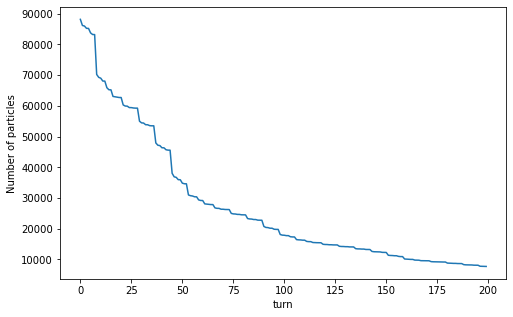

In [12]:
TCCS_xsuite.plot_alive()

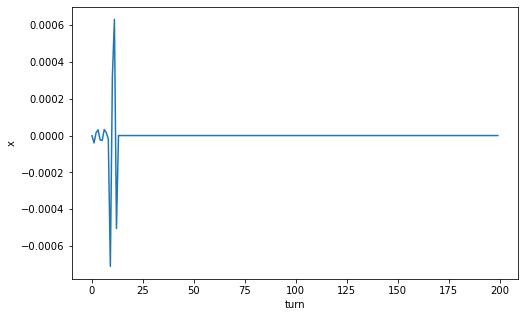

In [27]:
TCCS_xsuite.plot_particle_history('x', 70)

Total particles:  12944
Number of particles passed to the crystal multiple times:  207
Number particles gone through the crystal not dead the turn after:  4063
Number particles inside critical angle range:  10885


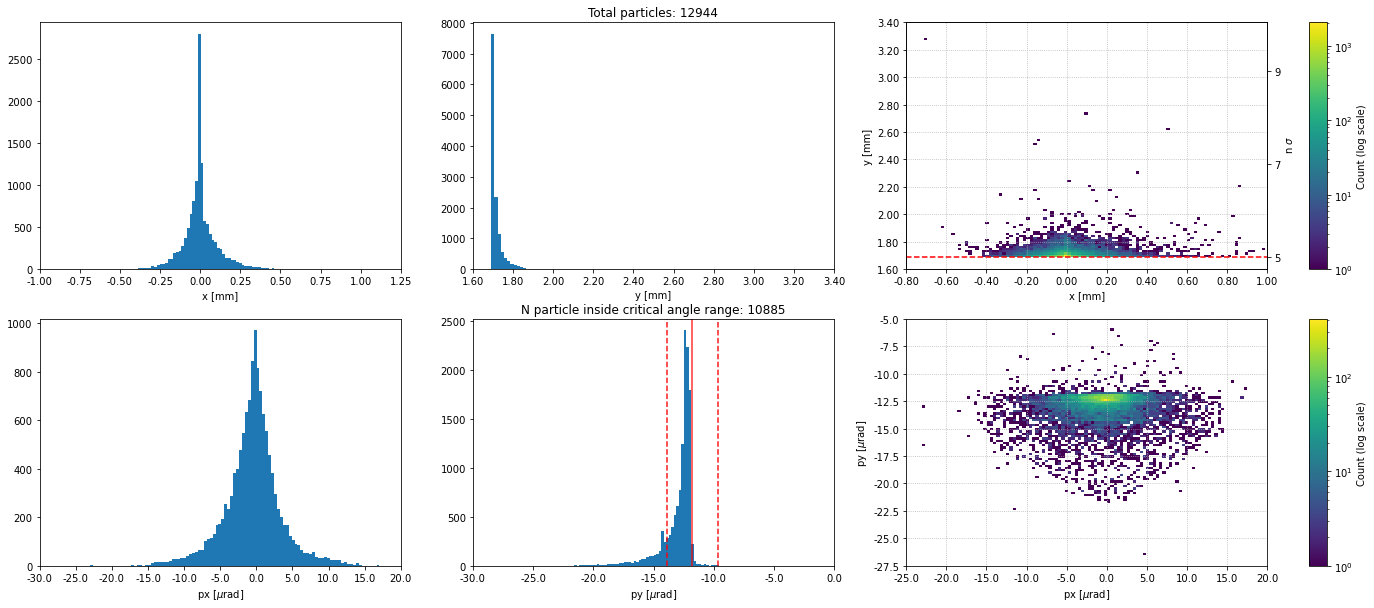

In [9]:
TCCS_xsuite.plot_impacting_particles(sigma=True, xpcrit= True)

Total particles:  8552
Number of particles passed to the crystal multiple times:  0
Number particles gone through the crystal not dead the turn after:  0
Mean py:  0.00014441555398818473


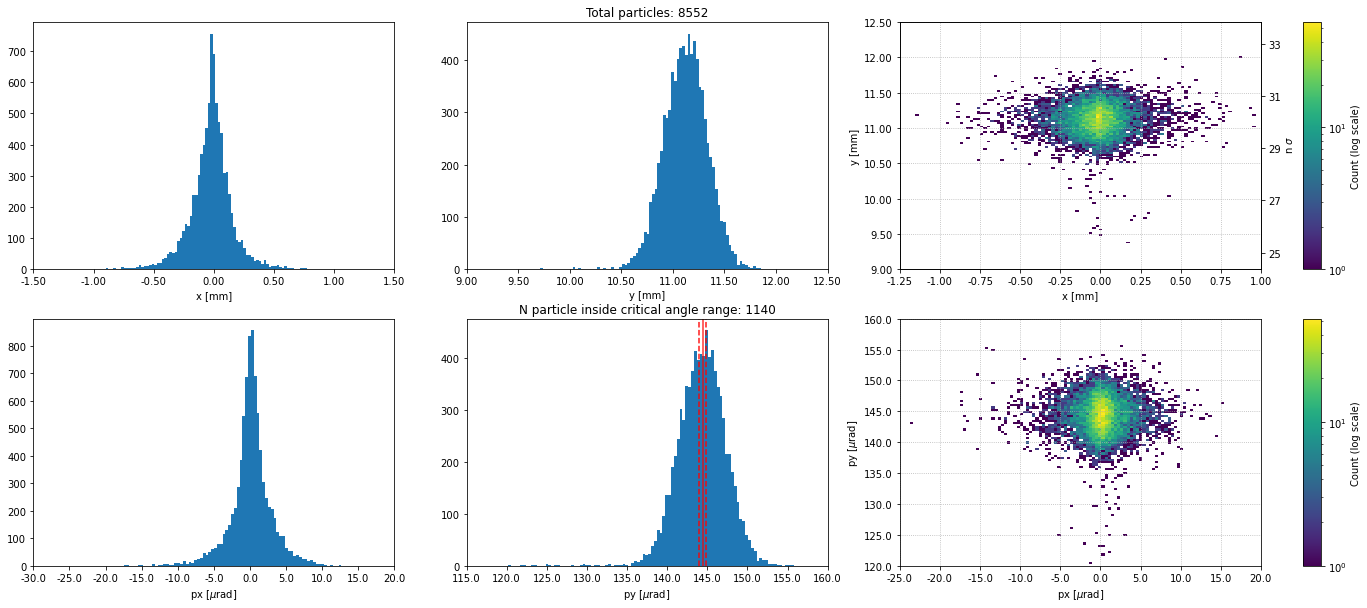

In [10]:
TCCP_xsuite.plot_impacting_particles( xpcrit=True, calculate_mean=True, lower_cut=137.0e-6, upper_cut=153.0e-6)

In [49]:
TCCP_xsuite.calculate_mean_py(lower_cut=137.0e-6, upper_cut=153.0e-6)

Mean py:  0.00014441555398818473


0.00014441555398818473

In [48]:
TCCP_xsuite.calculate_mean_py()

Mean py:  0.00014433115636470844


0.00014433115636470844

In [44]:
TCCP_xsuite.xp_crit

-4.834767326920944e-07

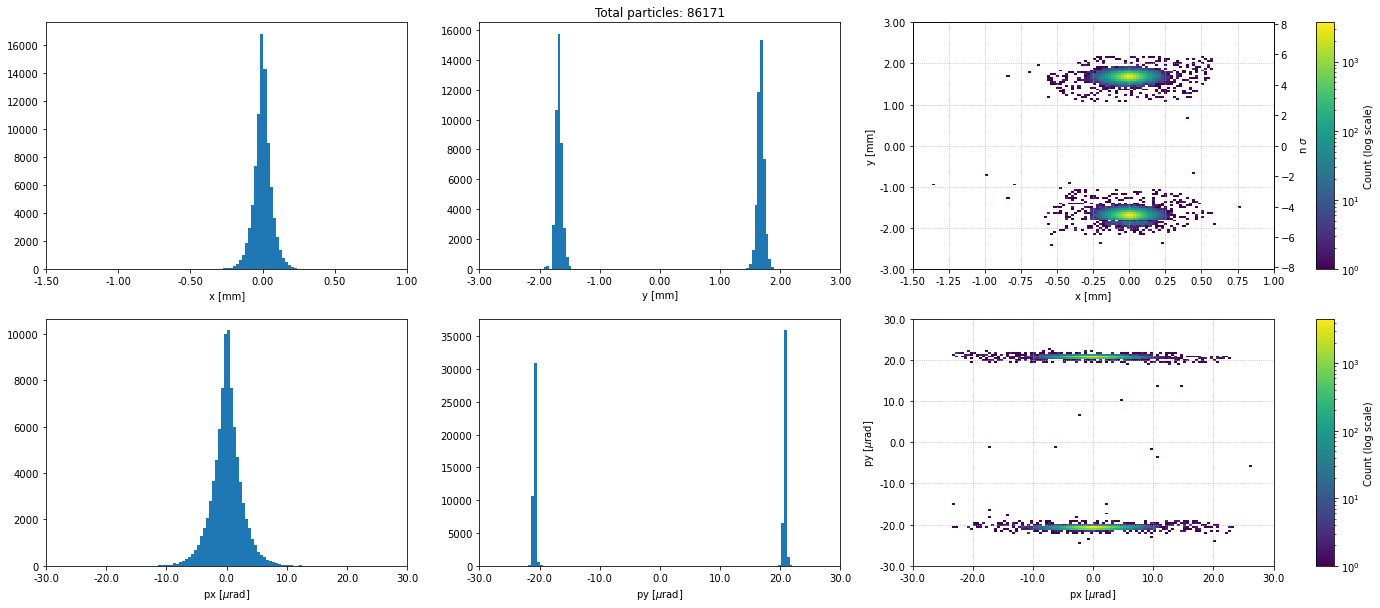

In [31]:
TCCP_xsuite.plot_distributions_at_turn(1, False)

In [54]:
TCCP_xsuite.count_upper_lower(150)

Alive particle after at crystal at 150 turn:  12290
Upper particles at crystal:  4780
Lower particles at crystal:  7510


Simple model

In [32]:
TCCS_simple.load(list(file_path_simple.glob(f"TCCS*"))[0])
#TARGET_simple.load(list(file_path_simple.glob(f"TARGET*"))[0])
TCCP_simple.load(list(file_path_simple.glob(f"TARGET*"))[0])

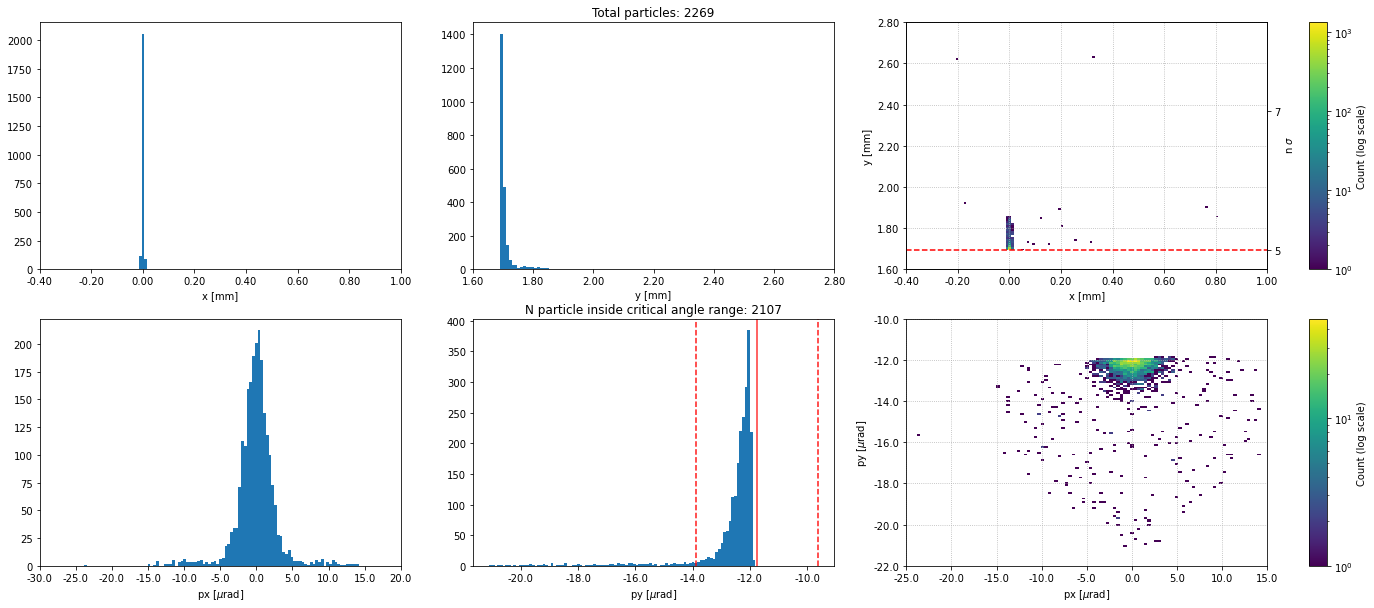

In [19]:
TCCS_simple.plot_impacting_particles(sigma=True, xpcrit= True)

In [23]:
TCCS_simple.xp_crit

2.13169286686969e-06

Total particles:  10936
Number of particles passed to the crystal multiple times:  0
Number particles gone through the crystal not dead the turn after:  0


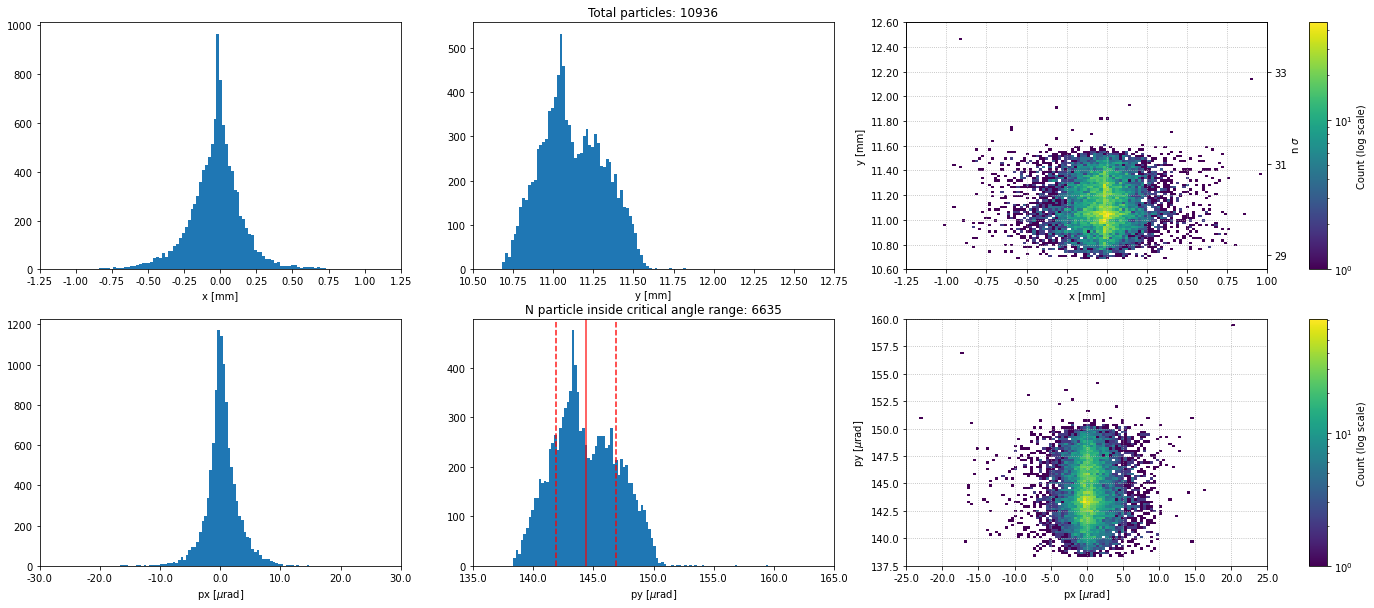

In [33]:
TCCP_simple.plot_impacting_particles(sigma=True, xpcrit= True, py_mean = 0.00014441555398818473)#TCCP_xsuite.calculate_mean_py(lower_cut=137.0e-6, upper_cut=153.0e-6))

In [21]:
TCCP_simple.xp_crit

-4.834767326920944e-07

In [22]:
pys = TCCP_simple.impact_part.py
py_mean = 0.00014441555398818473
chann_mask= (pys>py_mean - TCCP_simple.xp_crit)&(pys < py_mean + TCCP_simple.xp_crit)
print(py_mean, TCCP_simple.xp_crit)
for i in pys:
    print(i)

0.00014441555398818473 -4.834767326920944e-07
0.00014334440287060764
0.00014523562315855526
0.00014833806420474287
0.00014836671780272718
0.00014996024676709963
0.00014146216605126299
0.00014297971240856598
0.0001479345199144089
0.00014319640025519504
0.00014260746014457793
0.0001460572212295193
0.00014385153003836478
0.00014261089527221166
0.00014488994785337263
0.00014329223709709472
0.00013970977046220905
0.00014028333834652967
0.0001422058219705607
0.00014553546617981588
0.00014400128477852917
0.0001414260606338726
0.0001455506592114834
0.00014179537326507324
0.0001433271643225286
0.00014957151832999796
0.0001464668435021625
0.00014982127213256335
0.00014919880881029607
0.0001443832441161016
0.00013988565889432717
0.00014305962177167238
0.00014653310450376799
0.00014349177647974399
0.00014202941339114096
0.0001397663829715029
0.0001475987354022707
0.00014267515193235736
0.00014554859032306176
0.00014658165968027415
0.0001438881061208796
0.00014244984568816723
0.00014406677909132692

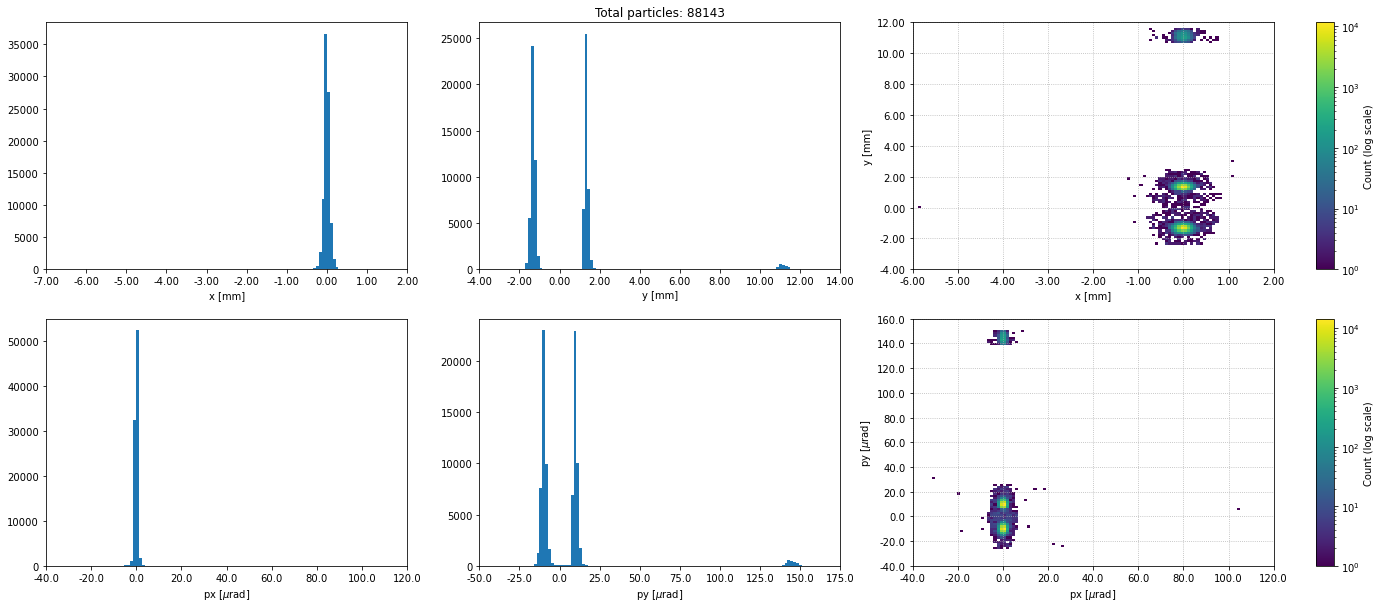

In [ ]:
TARGET_simple.plot_distributions_at_turn(0, False)

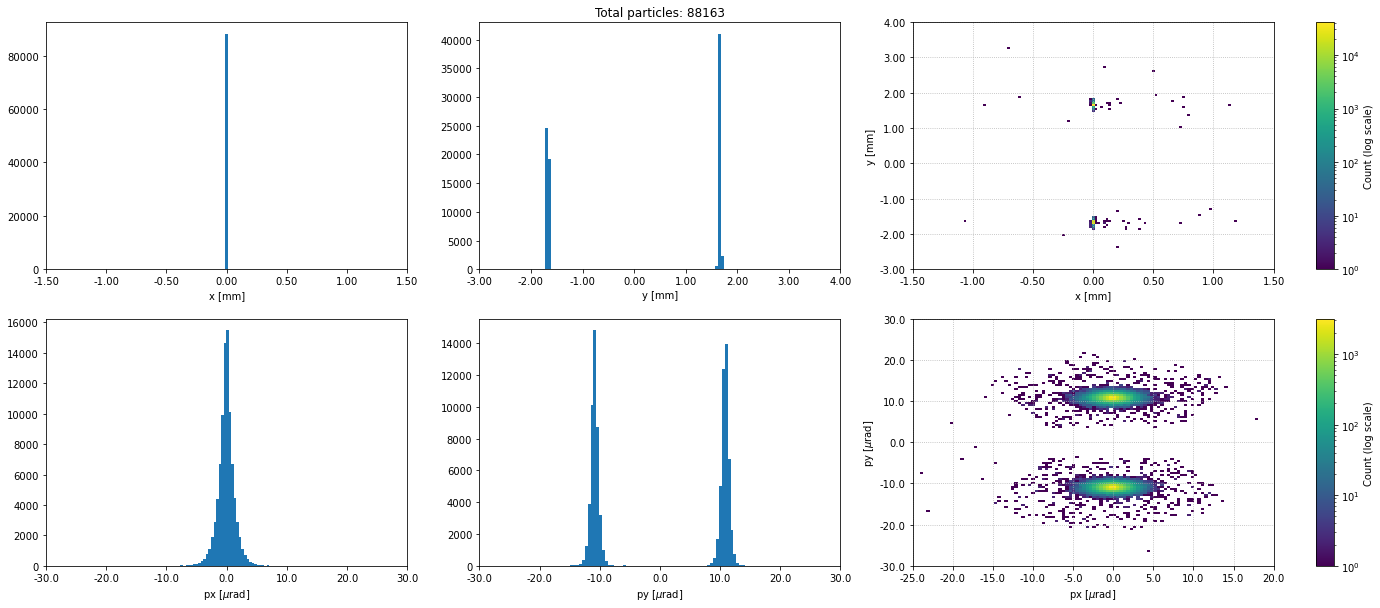

In [37]:
TCCS_xsuite.plot_distributions_at_turn(0, False)

In [12]:
TCCS_simple.impact_part